In [1]:
%load_ext lab_black
%load_ext autotime
import pandas as pd
import numpy as np

time: 261 ms (started: 2022-09-16 00:06:54 -07:00)


The [small NORB dataset](https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/), pairs of images at 96 x 96 resolution (= 9216 features) of 50 toys photographed at different angles and under different lighting conditions (in total, 972 different conditions per toy).

The NORB dataset eschews any typical image file format and instead describes its own. This is well-documented on the website as linked above. If you would rather use an external package to fetch this data, it is part of the [tensorflow datasets](https://www.tensorflow.org/datasets/catalog/smallnorb) as well as having its own package, [small_norb](https://github.com/ndrplz/small_norb).

This data set can take up quite a bit of RAM compared to other datasets used here (e.g. the training set takes up around 18 GB and that's before any reshaping into a numpy array). Some ways to help with this:

* using the `struct` python library we will be unpacking the bytes into `int` values, but we only need to store 8-bit unsigned integers. So we will read one image at a time into an `int` buffer, then store that in a `np.uint8` numpy array.
* there's not a lot of interest from a dimensionality reduction perspective from storing both images of the pair: they look very similar. So we will just store the first image and skip the second in the pair.

This will keep the storage of NORB to around 1GB but be warned, when it's time to process it for nearest neighbors and so on, we will end up casting the data to floating point, which will balloon the required storage in memory.

Here are some facts about the data we will be reading:

In [2]:
n_elevations = 9
n_azimuths = 18
n_lightings = 6
n_images_per_pose = 2
n_poses = n_elevations * n_azimuths * n_lightings
n_objects_per_category = 5

n_training_categories = 5
n_training_objects = n_training_categories * n_objects_per_category
n_training_images = n_training_objects * n_poses

n_test_categories = 5
n_test_objects = n_test_categories * n_objects_per_category
n_test_images = n_test_objects * n_poses

n_images = n_training_images + n_test_images

nx = 96
ny = 96
n_features = nx * ny

time: 3.42 ms (started: 2022-09-16 00:06:54 -07:00)


And this is the code we will need to download the binary and integer matrix data. The website lists other supported types (as can be seen in `magic_to_type`), but we only need byte and integer matrices for the small NORB dataset.

In [3]:
import gzip
from io import BytesIO
from struct import unpack

import requests

magic_to_type = {
    "0x1e3d4c51": "single",
    "0x1e3d4c52": "packed",
    "0x1e3d4c53": "double",
    "0x1e3d4c54": "integer",
    "0x1e3d4c55": "byte",
    "0x1e3d4c56": "short",
}

type_to_bytes_per_feature = dict(byte=1, integer=4)
type_to_struct_format = dict(byte="B", integer="I")
type_to_dtype = dict(byte=np.uint8, integer=int)

# throughout, "<" indicates big-endian (which is how the data was generated)
def read_header(f):
    magic = unpack("<I", f.read(4))[0]
    matrix_type = magic_to_type.get(hex(magic), "unknown")
    if matrix_type == "unknown":
        raise ValueError(f"Unknown matrix type for bad magic: {magic}")
    ndim = unpack("<I", f.read(4))[0]
    # dim is always at least 3 integers, but ignore after the first ndim if ndim < 3
    dim_to_read = max(ndim, 3)
    dim = unpack("<" + ("I" * dim_to_read), f.read(4 * dim_to_read))
    print(f"Reading {matrix_type} matrix with dim {dim[:ndim]}")
    return ndim, dim, matrix_type


def read_binary_matrix(f):
    ndim, dim, matrix_type = read_header(f)
    bytes_per_feature = type_to_bytes_per_feature[matrix_type]
    struct_format = type_to_struct_format[matrix_type]
    data = np.empty(dim[:ndim], dtype=type_to_dtype[matrix_type])
    features_per_read = int(np.prod(dim[1:ndim]))
    bytes_per_read = bytes_per_feature * features_per_read
    struct_fmt = "<" + (struct_format * features_per_read)

    for i in range(dim[0]):
        unpacked = unpack(
            struct_fmt,
            f.read(bytes_per_read),
        )
        if len(unpacked) == 1:
            data[i] = unpacked[0]
        else:
            data[i] = np.array(unpacked).reshape(dim[1:ndim])

    return data


def read_binary_matrix_url(url):
    req = requests.get(url, timeout=10)

    with gzip.open(BytesIO(req.content), "rb") as f:
        return read_binary_matrix(f)

time: 45.5 ms (started: 2022-09-16 00:06:54 -07:00)


## Read training data

### Training categories

In [4]:
training_cat_data = read_binary_matrix_url(
    "https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat.gz"
)

training_cat_data.shape, training_cat_data[:10]

Reading integer matrix with dim (24300,)


((24300,), array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4]))

time: 498 ms (started: 2022-09-16 00:06:54 -07:00)


### Training info

In [5]:
training_info_data = read_binary_matrix_url(
    "https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x46789x9x18x6x2x96x96-training-info.mat.gz"
)

training_info_data.shape, training_info_data[:10]

Reading integer matrix with dim (24300, 4)


((24300, 4),
 array([[ 8,  6,  4,  4],
        [ 8,  2,  6,  4],
        [ 4,  8, 24,  3],
        [ 7,  8, 28,  0],
        [ 8,  7, 20,  0],
        [ 8,  7,  8,  1],
        [ 9,  6, 12,  0],
        [ 7,  7,  4,  2],
        [ 7,  3, 20,  0],
        [ 6,  7, 24,  1]]))

time: 507 ms (started: 2022-09-16 00:06:55 -07:00)


### Training images

**NB** this will take a bit longer than the other files, but should take up less than 1GB of RAM:

In [6]:
training_img_data = read_binary_matrix_url(
    "https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat.gz"
)

training_img_data.shape, training_img_data[0]

Reading byte matrix with dim (24300, 2, 96, 96)


((24300, 2, 96, 96),
 array([[[174, 174, 174, ..., 174, 174, 174],
         [174, 174, 174, ..., 174, 174, 174],
         [174, 174, 174, ..., 174, 174, 174],
         ...,
         [173, 173, 172, ..., 172, 173, 173],
         [173, 173, 172, ..., 173, 172, 172],
         [173, 173, 172, ..., 173, 172, 172]],
 
        [[173, 173, 173, ..., 173, 173, 173],
         [174, 174, 174, ..., 173, 173, 173],
         [174, 174, 174, ..., 174, 173, 173],
         ...,
         [173, 172, 171, ..., 172, 171, 171],
         [173, 172, 171, ..., 172, 172, 172],
         [173, 172, 172, ..., 172, 172, 172]]], dtype=uint8))

time: 31.5 s (started: 2022-09-16 00:06:55 -07:00)


## View object image

Just to make sure we read that data in ok:

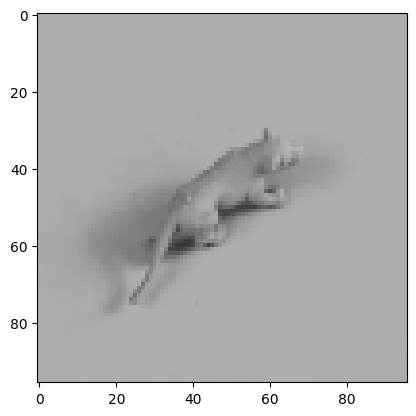

time: 689 ms (started: 2022-09-16 00:07:27 -07:00)


In [7]:
import matplotlib.pyplot as plt

plt.imshow(
    training_img_data[0][0],
    cmap=plt.cm.gray,
    interpolation="nearest",
    vmin=0,
    vmax=255,
)

Looks good, let's move onto the test data.

## Read the test data

### Test categories

In [8]:
test_cat_data = read_binary_matrix_url(
    "https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x01235x9x18x6x2x96x96-testing-cat.mat.gz"
)

test_cat_data.shape, test_cat_data[:10]

Reading integer matrix with dim (24300,)


((24300,), array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4]))

time: 356 ms (started: 2022-09-16 00:07:28 -07:00)


### Test info

In [9]:
test_info_data = read_binary_matrix_url(
    "https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x01235x9x18x6x2x96x96-testing-info.mat.gz"
)

test_info_data.shape, test_info_data[:10]

Reading integer matrix with dim (24300, 4)


((24300, 4),
 array([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1]]))

time: 388 ms (started: 2022-09-16 00:07:28 -07:00)


### Test images

In [10]:
test_img_data = read_binary_matrix_url(
    "https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x01235x9x18x6x2x96x96-testing-dat.mat.gz"
)

test_img_data.shape, test_img_data[0]

Reading byte matrix with dim (24300, 2, 96, 96)


((24300, 2, 96, 96),
 array([[[225, 225, 225, ..., 225, 225, 225],
         [225, 225, 225, ..., 225, 225, 225],
         [225, 225, 225, ..., 225, 225, 225],
         ...,
         [225, 225, 225, ..., 224, 224, 224],
         [225, 225, 225, ..., 224, 224, 224],
         [225, 225, 225, ..., 224, 224, 224]],
 
        [[225, 225, 225, ..., 225, 225, 225],
         [225, 225, 225, ..., 225, 225, 225],
         [225, 225, 225, ..., 225, 225, 225],
         ...,
         [224, 224, 225, ..., 224, 224, 224],
         [224, 224, 225, ..., 224, 224, 224],
         [224, 224, 225, ..., 224, 224, 224]]], dtype=uint8))

time: 31.7 s (started: 2022-09-16 00:07:28 -07:00)


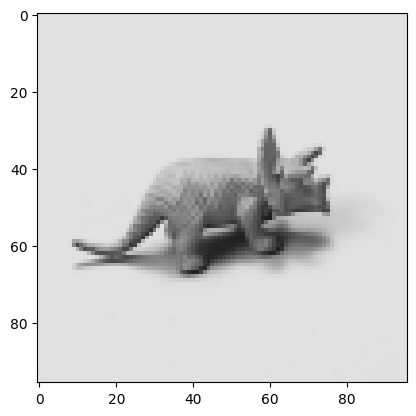

time: 115 ms (started: 2022-09-16 00:08:00 -07:00)


In [11]:
plt.imshow(
    test_img_data[0][1],
    cmap=plt.cm.gray,
    interpolation="nearest",
    vmin=0,
    vmax=255,
)

## Flatten

It's time to flatten the dataset and also discard one of the images in each pair. Arbitrarily, I will keep the first one. Yes, we could have just not read the data in the first place, but then we couldn't have taken advantage of the same `read_binary_matrix` function the category and info matrices use.

In [12]:
training_img_data_flat = training_img_data[:, 0].reshape((24300, 96 * 96))
training_img_data_flat.shape

(24300, 9216)

time: 4 ms (started: 2022-09-16 00:08:00 -07:00)


Let's just check we can still view the image:

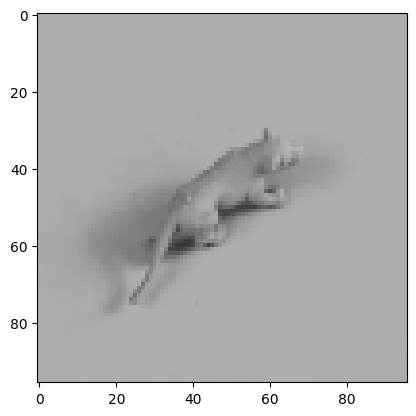

time: 108 ms (started: 2022-09-16 00:08:00 -07:00)


In [13]:
plt.imshow(
    training_img_data_flat[0].reshape((96, 96)),
    cmap=plt.cm.gray,
    interpolation="nearest",
    vmin=0,
    vmax=255,
)

In [14]:
test_img_data_flat = test_img_data[:, 0].reshape((24300, 96 * 96))
test_img_data_flat.shape

(24300, 9216)

time: 4.34 ms (started: 2022-09-16 00:08:00 -07:00)


## Merge the training and test data

In [15]:
img_data = np.vstack((training_img_data_flat, test_img_data_flat))
img_data.shape

(48600, 9216)

time: 143 ms (started: 2022-09-16 00:08:00 -07:00)


Merging the metadata columns is a bit more work. In one go here, we add the category column to the end of the info matrix, then merge the combined training and test data (the `reshape` is a bit regrettable but it's necessary to turn the category data into a 2D array for `np.append` to work):

In [16]:
target = np.vstack(
    (
        np.append(
            training_info_data,
            training_cat_data.reshape(training_cat_data.shape[0], 1),
            axis=1,
        ),
        np.append(
            test_info_data, test_cat_data.reshape(test_cat_data.shape[0], 1), axis=1
        ),
    )
)

time: 5.44 ms (started: 2022-09-16 00:08:00 -07:00)


In [17]:
target, target.shape

(array([[ 8,  6,  4,  4,  0],
        [ 8,  2,  6,  4,  1],
        [ 4,  8, 24,  3,  2],
        ...,
        [ 5,  8, 34,  5,  2],
        [ 5,  8, 34,  5,  3],
        [ 5,  8, 34,  5,  4]]),
 (48600, 5))

time: 5.39 ms (started: 2022-09-16 00:08:00 -07:00)


The last column is the category column, but the categories do have a simple label name:

In [18]:
norb_descriptions = np.array(["Animal", "Human", "Airplane", "Truck", "Car"])

time: 3.22 ms (started: 2022-09-16 00:08:00 -07:00)


by keying into the `category` column we can create a column of descriptions:

In [19]:
desc_column = np.array(norb_descriptions)[target[:, -1]].reshape((target.shape[0], 1))

time: 3.2 ms (started: 2022-09-16 00:08:00 -07:00)


In [20]:
desc_column

array([['Animal'],
       ['Human'],
       ['Airplane'],
       ...,
       ['Airplane'],
       ['Truck'],
       ['Car']], dtype='<U8')

time: 3.62 ms (started: 2022-09-16 00:08:00 -07:00)


In [21]:
target = pd.DataFrame(
    np.append(target, desc_column, axis=1),
    columns=["Instance", "Elevation", "Azimuth", "Lighting", "Category", "Description"],
)

time: 117 ms (started: 2022-09-16 00:08:00 -07:00)


In [22]:
target

,Instance,Elevation,Azimuth,Lighting,Category,Description
0,8,6,4,4,0,Animal
1,8,2,6,4,1,Human
2,4,8,24,3,2,Airplane
3,7,8,28,0,3,Truck
4,8,7,20,0,4,Car
...,...,...,...,...,...,...
48595,5,8,34,5,0,Animal
48596,5,8,34,5,1,Human
48597,5,8,34,5,2,Airplane
48598,5,8,34,5,3,Truck


time: 10.3 ms (started: 2022-09-16 00:08:01 -07:00)


## Pipeline

Our beautiful efficient memory use is about to get blown up by converting the image data from 8-bit integers to 32-bit floats for the processing. Hang onto your memory sticks:

In [23]:
from drnb.io.pipeline import create_default_pipeline

data_result = create_default_pipeline(check_for_duplicates=True).run(
    "norb",
    data=img_data,
    target=target,
    tags=["image", "highdim"],
    url="https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/",
    verbose=True,
)

[00:08:05] INFO     Requesting one extra neighbor to account for self-neighbor                      ]8;id=376927;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=437721;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#392\392]8;;\

           INFO     Initial data shape: (48600, 9216)                                                ]8;id=840793;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=382178;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#80\80]8;;\

           INFO     Keeping all columns                                                            ]8;id=772777;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=228129;file:///home/james/dev/drnb/src/drnb/preprocess.py#62\62]8;;\

           INFO     Data shape after filtering columns: (48600, 9216)                               ]8;id=80512;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=556088;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#151\151]8;;\

           INFO     Removing rows with NAs                                                          ]8;id=868177;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=809200;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#135\135]8;;\

           INFO     Data shape after filtering NAs: (48600, 9216)                                   ]8;id=922519;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=792127;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#146\146]8;;\

[00:08:22] INFO     Checked for duplicates: found 0                                                 ]8;id=704837;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=993436;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#158\158]8;;\

           INFO     No scaling                                                                     ]8;id=889962;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=241007;file:///home/james/dev/drnb/src/drnb/preprocess.py#25\25]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}                    ]8;id=134799;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=633576;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#163\163]8;;\

[00:08:23] INFO     Writing data for norb                                                           ]8;id=555978;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=616550;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#225\225]8;;\

[00:10:57] INFO     Processing target with initial shape (48600, 6)                                 ]8;id=91203;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=792581;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#196\196]8;;\

           INFO     Keeping all columns                                                            ]8;id=664076;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=415864;file:///home/james/dev/drnb/src/drnb/preprocess.py#62\62]8;;\

           INFO     Writing target for norb                                                         ]8;id=827052;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=668544;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#225\225]8;;\

           INFO     Calculating nearest neighbors                                                   ]8;id=424230;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=70055;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#240\240]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and params: {}           ]8;id=987227;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=674744;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#71\71]8;;\

           INFO     Loading faiss with AVX2 support.                                                   ]8;id=570773;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=877248;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=547269;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=406308;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=528018;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=613038;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

           INFO     Successfully loaded faiss.                                                         ]8;id=104777;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=117414;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

[00:11:43] INFO     Calculating triplets                                                            ]8;id=821353;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=707284;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#276\276]8;;\

[00:11:48] INFO     Writing csv format to triplets/norb.5.1337.idx.csv                              ]8;id=711771;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=903799;file:///home/james/dev/drnb/src/drnb/io/__init__.py#221\221]8;;\

[00:11:49] INFO     Writing csv format to triplets/norb.5.1337.l2.csv                               ]8;id=471521;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=35469;file:///home/james/dev/drnb/src/drnb/io/__init__.py#221\221]8;;\

[00:11:50] INFO     Writing numpy format to triplets/norb.5.1337.idx.npy                            ]8;id=808667;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=981274;file:///home/james/dev/drnb/src/drnb/io/__init__.py#244\244]8;;\

           INFO     Writing numpy format to triplets/norb.5.1337.l2.npy                             ]8;id=935649;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=568668;file:///home/james/dev/drnb/src/drnb/io/__init__.py#244\244]8;;\

           INFO     Writing pipeline result for norb                                                ]8;id=208099;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=104220;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#128\128]8;;\

time: 3min 49s (started: 2022-09-16 00:08:01 -07:00)
